# Benchmark model - Impairment - Sequential Timewise Exploration, calibration, test

This notebook uses as inputs the outputs from the pipeline ('05_preproc_pipeline_1.ipynb' notebook) and performs model calibration and general exploration for the transaction credit events prediction.

In [1]:
import pandas as pd
import numpy as np
import pickle
from os import environ

from sklearn.model_selection import cross_val_predict, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from scripts_viz.visualization_utils import *
from scripts_ml.models_utils import *

from bokeh.io import show, output_notebook
output_notebook()

import datetime as dt

Loading BokehJS ...

### TRAIN Data import

In [2]:
#importing data
preproc_folder = "enriched_time_seq"
datafolder = "../data/preproc_traintest/"+preproc_folder+'/'
prefix_time_seq = 'time_2018-02-20_p180_bg_'
valid_code = '_val_26000_2000_'
trainfile = '_traindata'
testfile = '_testdata'
postfix_time_seq_val = '_190824_1812'
postfix_time_seq = '_190824_1321'
preproc_folder = "enriched_time_seq"
datafolder = "../data/preproc_traintest/"+preproc_folder+'/'
indexfile = '_fold_indexes'
expname = preproc_folder+"_p180"

[X_train, y_train, feature_labels] = pd.read_pickle(datafolder+prefix_time_seq+trainfile+postfix_time_seq+'.pkl') 
[X_test, y_test, feature_labels] = pd.read_pickle(datafolder+prefix_time_seq+testfile+postfix_time_seq+'.pkl') 
[val_X_train, val_y_train, val_feature_labels] = pd.read_pickle(datafolder+prefix_time_seq+valid_code+trainfile+postfix_time_seq_val+'.pkl') 
[val_X_test, val_y_test, val_feature_labels] = pd.read_pickle(datafolder+prefix_time_seq+valid_code+testfile+postfix_time_seq_val+'.pkl') 
indexes = pd.read_pickle(datafolder+prefix_time_seq+valid_code+indexfile+postfix_time_seq_val+'.pkl')

In [3]:
#recombining folds for grid search

val_X_all = []
val_y_all = []
indexes_tuples = []

count=0
start_tr=0

for idx in indexes:
    val_X_all.append(val_X_train[idx[0]])
    val_y_all.append(val_y_train[idx[0]])
    if count==0:
        test_idx = np.array(range(0, len(idx[1])))
    else:
        test_idx+=len(idx[1])
    val_X_all.append(val_X_test[test_idx])
    val_y_all.append(val_y_test[test_idx])
    
    
    if count==0:
        start_tst = len(idx[0])
    else:
        start_tr+=add_to_tr
        start_tst=start_tr+len(idx[0])
        
    indexes_tuples.append((np.array(range(start_tr, start_tr+len(idx[0]))), 
                          np.array(range(start_tst, start_tst+len(idx[1])))))
    
    add_to_tr = len(idx[0])+len(idx[1])
    
    count+=1
        

In [4]:
indexes_tuples

[(array([    0,     1,     2, ..., 26076, 26077, 26078]),
  array([26079, 26080, 26081, ..., 28076, 28077, 28078])),
 (array([28079, 28080, 28081, ..., 54076, 54077, 54078]),
  array([54079, 54080, 54081, ..., 56076, 56077, 56078])),
 (array([56079, 56080, 56081, ..., 82076, 82077, 82078]),
  array([82079, 82080, 82081, ..., 84076, 84077, 84078])),
 (array([ 84079,  84080,  84081, ..., 110076, 110077, 110078]),
  array([110079, 110080, 110081, ..., 112076, 112077, 112078])),
 (array([112079, 112080, 112081, ..., 138076, 138077, 138078]),
  array([138079, 138080, 138081, ..., 140076, 140077, 140078])),
 (array([140079, 140080, 140081, ..., 166076, 166077, 166078]),
  array([166079, 166080, 166081, ..., 168076, 168077, 168078])),
 (array([168079, 168080, 168081, ..., 194076, 194077, 194078]),
  array([194079, 194080, 194081, ..., 196076, 196077, 196078])),
 (array([196079, 196080, 196081, ..., 222076, 222077, 222078]),
  array([222079, 222080, 222081, ..., 224076, 224077, 224078]))]

In [5]:
val_X_all = np.concatenate(val_X_all, axis=0)
val_y_all = np.concatenate(val_y_all, axis=0)

In [6]:
val_X_all.shape

(224079, 35)

In [7]:
val_X_all_df = pd.DataFrame(val_X_all, columns=feature_labels)
val_X_all_df.head()

,currency_Schweizer Franken,currency_Euro,currency_US-Dollar,currency_Britisches Pfund,has_purchase,dd_value_date,cd_lent_c,cd_repaid_c,cd_impaired1_c,cd_pastdue90_c,...,flow_shock_p90,p90_c_node_eff,p90_energy,p90_d_node_flow,flow_shock_p180,p180_d_node_flow,p180_energy,invoice_amount,purchase_amount,invoice_date
0,0.369242,-0.3557,-0.067705,-0.055818,-2.208234,0.295312,-0.595617,-0.44663,-0.171642,-0.080522,...,-0.333628,-0.324565,-0.299649,-0.219761,-0.333628,-0.219761,-0.299649,-0.805568,-2.152879,-4.047954
1,0.369242,-0.3557,-0.067705,-0.055818,-2.208234,0.295312,-0.584787,-0.44663,-0.171642,-0.080522,...,-0.333628,-0.324565,-0.299649,-0.219761,-0.333628,-0.219761,-0.299649,-0.160118,-2.152879,-4.047954
2,0.369242,-0.3557,-0.067705,-0.055818,-2.208234,0.295312,-0.573956,-0.44663,-0.171642,-0.080522,...,-0.333628,-0.324565,-0.299649,-0.219761,-0.333628,-0.219761,-0.299649,-0.512792,-2.152879,-4.047954
3,0.369242,-0.3557,-0.067705,-0.055818,-2.208234,0.295312,-0.595617,-0.44663,-0.171642,-0.080522,...,-0.333628,-0.479402,-0.299849,-0.353480,-0.333628,-0.353480,-0.299849,0.861801,-2.152879,-4.047954
4,0.369242,-0.3557,-0.067705,-0.055818,-2.208234,0.295312,-0.595617,-0.44663,-0.171642,-0.080522,...,-0.333628,-0.479402,-0.299849,-0.092302,-0.333628,-0.092302,-0.299849,0.360787,-2.152879,-4.047954


In [8]:
val_X_all_df.columns

Index(['currency_Schweizer Franken', 'currency_Euro', 'currency_US-Dollar',
       'currency_Britisches Pfund', 'has_purchase', 'dd_value_date',
       'cd_lent_c', 'cd_repaid_c', 'cd_impaired1_c', 'cd_pastdue90_c',
       'cd_trend_a', 'c_lent_c', 'c_repaid_c', 'c_impaired1_c',
       'c_pastdue90_c', 'c_trend_a', 'd_repaid_c', 'd_impaired1_c',
       'd_pastdue90_c', 'd_trend_a', 'd_we_payment_share', 'flow_shock_imp1',
       'imp_c_node_eff', 'imp_energy', 'imp_d_node_flow', 'flow_shock_p90',
       'p90_c_node_eff', 'p90_energy', 'p90_d_node_flow', 'flow_shock_p180',
       'p180_d_node_flow', 'p180_energy', 'invoice_amount', 'purchase_amount',
       'invoice_date'],
      dtype='object')

In [10]:
val_X_all_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
currency_Schweizer Franken,224079.0,-0.002857,1.003131,-3.637441,0.363264,0.369242,0.369242,0.369242
currency_Euro,224079.0,0.001928,1.002213,-0.355700,-0.355700,-0.355700,-0.349140,3.869175
currency_US-Dollar,224079.0,0.001294,1.011746,-0.087823,-0.069505,-0.067705,-0.067705,14.769944
currency_Britisches Pfund,224079.0,0.004172,1.022424,-0.055903,-0.055903,-0.055818,-0.055818,17.915440
has_purchase,224079.0,0.051266,0.947522,-2.442698,0.409383,0.452851,0.452851,0.482445
dd_value_date,224079.0,-0.056105,0.855407,-0.200860,-0.200860,-0.200860,-0.101562,88.242500
cd_lent_c,224079.0,0.035769,1.043960,-0.622712,-0.550319,-0.411498,0.075876,4.187763
cd_repaid_c,224079.0,0.051698,1.055477,-0.526951,-0.446630,-0.395254,-0.035619,4.613230
cd_impaired1_c,224079.0,0.018765,1.058411,-0.197865,-0.177414,-0.171642,-0.171642,8.151007
cd_pastdue90_c,224079.0,-0.001261,0.910257,-0.176802,-0.080522,-0.080522,-0.044333,22.556683


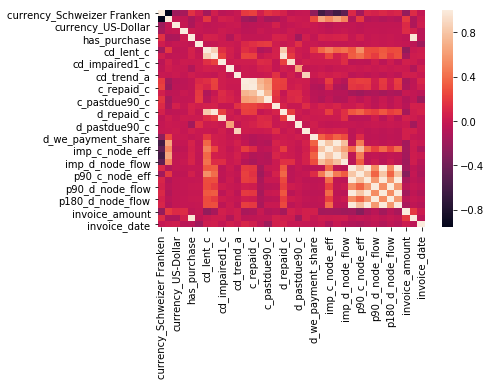

In [11]:
sns.heatmap(val_X_all_df.corr())

### SGD Classifier

In [12]:
#Linear model Stochastic Gradient Descent
sgd_clf = SGDClassifier(random_state=42, max_iter=250, loss='log', tol=0.0001) 
sgd_clf_diag = model_diag_seq(sgd_clf, val_X_train, val_y_train, specify_idxs=True, idx_tuples=indexes, X_test=val_X_test, y_test=val_y_test)

Fold 1: train  on 26079 from index 0 to 26078, test on 2000 from 0 to 1999
Fold 1 AUC: 0.8258834711888305
Fold 2: train  on 26000 from index 2079 to 28078, test on 2000 from 2000 to 3999
Fold 2 AUC: 0.40358256324642877
Fold 3: train  on 26000 from index 4079 to 30078, test on 2000 from 4000 to 5999
Fold 3 AUC: 0.7932958692276773
Fold 4: train  on 26000 from index 6079 to 32078, test on 2000 from 6000 to 7999
Fold 4 AUC: 0.5301717936174499
Fold 5: train  on 26000 from index 8079 to 34078, test on 2000 from 8000 to 9999
Fold 5 AUC: 0.6086400181984916
Fold 6: train  on 26000 from index 10079 to 36078, test on 2000 from 10000 to 11999
Fold 6 AUC: 0.544486728076727
Fold 7: train  on 26000 from index 12079 to 38078, test on 2000 from 12000 to 13999
Fold 7 AUC: 0.45811823351930303
Fold 8: train  on 26000 from index 14079 to 40078, test on 2000 from 14000 to 15999
Fold 8 AUC: 0.5167538411245506
Validation AUC 0.566


In [13]:
sgd_clf.fit(X_train, y_train)
y_score_sgd = sgd_clf.predict(X_test)
cm = confusion_matrix(y_test, y_score_sgd)
print(cm)
sgd_test_diag = model_oostest(sgd_clf,X_test, y_test)
sgd_test_auc = plot_rocs([sgd_clf_diag, sgd_test_diag], p_width=600, p_height=600, model_appendix=['SGD - seq_valid','SGD - test'])
show(sgd_test_auc)

[[14839   647]
 [   52     2]]
Confusion matrix: 
[[0.95822 0.04178]
 [0.00336 0.00013]]
AUC 0.731


In [14]:
#save_sk_model(sgd_clf, "../data/models/", 'sgd', 'benchmark')

In [21]:
scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}

# max Number of iterations
max_iter = [80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400] 
# learning rate
learning_rate = ['constant', 'optimal', 'adaptive']
#eta
eta0 = [0.00001, 0.0001, 0.001, 0.01]
#loss
loss = ['log', 'hinge']

param_grid = {'max_iter': max_iter,
               'learning_rate': learning_rate,
                  'eta0': eta0,
                  'loss':loss}

sgd = SGDClassifier(tol=0.0001)

sgd_gsearch = GridSearchCV(estimator = sgd, param_grid = param_grid, #param_distributions = sgd_random_grid, 
                           cv = rolling_window_idxs(indexes_tuples),   
                                 verbose=2, n_jobs =-1, scoring=scoring, refit='AUC')
# Fit the random search model
sgd_gsearch.fit(val_X_all, val_y_all)

Fitting 8 folds for each of 408 candidates, totalling 3264 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 3264 out of 3264 | elapsed:  5.2min finished


GridSearchCV(cv=<generator object rolling_window_idxs at 0x7f9f5cd6a258>,
             error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0....
             iid='warn', n_jobs=-1,
             param_grid={'eta0': [1e-05, 0.0001, 0.001, 0.01],
                         'learning_rate': ['constant', 'optimal', 'adaptive'],
                         'loss': ['log', 'hinge'],
                         'max_iter': [80, 100, 120, 140, 160, 180, 200, 220,
                                      240, 260, 280, 300, 320, 340, 360,

In [23]:
sgd_gsearch.best_params_

{'eta0': 1e-05, 'learning_rate': 'optimal', 'loss': 'log', 'max_iter': 360}

In [24]:
#Linear model Stochastic Gradient Descent
sgd_gs = SGDClassifier(random_state=42, max_iter=360, loss='log', learning_rate='optimal', eta0=1e-05, tol=0.0001) 
sgd_gs_diag = model_diag_seq(sgd_gs, val_X_train, val_y_train, specify_idxs=True, idx_tuples=indexes, X_test=val_X_test, y_test=val_y_test)

Fold 1: train  on 26079 from index 0 to 26078, test on 2000 from 0 to 1999
Fold 1 AUC: 0.8258834711888305
Fold 2: train  on 26000 from index 2079 to 28078, test on 2000 from 2000 to 3999
Fold 2 AUC: 0.40358256324642877
Fold 3: train  on 26000 from index 4079 to 30078, test on 2000 from 4000 to 5999
Fold 3 AUC: 0.7932958692276773
Fold 4: train  on 26000 from index 6079 to 32078, test on 2000 from 6000 to 7999
Fold 4 AUC: 0.5301717936174499
Fold 5: train  on 26000 from index 8079 to 34078, test on 2000 from 8000 to 9999
Fold 5 AUC: 0.6086400181984916
Fold 6: train  on 26000 from index 10079 to 36078, test on 2000 from 10000 to 11999
Fold 6 AUC: 0.544486728076727
Fold 7: train  on 26000 from index 12079 to 38078, test on 2000 from 12000 to 13999
Fold 7 AUC: 0.45811823351930303
Fold 8: train  on 26000 from index 14079 to 40078, test on 2000 from 14000 to 15999
Fold 8 AUC: 0.5167538411245506
Validation AUC 0.566


In [25]:
sgd_gs.fit(X_train, y_train)
y_score_sgd_gs = sgd_gs.predict(X_test)
cm = confusion_matrix(y_test, y_score_sgd_gs)
print(cm)
sgd_test_diag_gs = model_oostest(sgd_gs,X_test, y_test)
sgd_test_auc_gs = plot_rocs([sgd_gs_diag, sgd_test_diag_gs], p_width=600, p_height=600, model_appendix=['SGD - seq_valid','SGD - test'])
show(sgd_test_auc_gs)

[[14839   647]
 [   52     2]]
Confusion matrix: 
[[0.95822 0.04178]
 [0.00336 0.00013]]
AUC 0.731


### Random Forest Classifier

In [26]:
#random forest - benchmark
n_estimators = 200
max_leaf_nodes = 40
rf_clf = RandomForestClassifier(random_state=42,
                               n_estimators=n_estimators,
                               max_leaf_nodes=max_leaf_nodes,
                               class_weight="balanced",
                               n_jobs=7)

rf_clf_diag = model_diag_seq(rf_clf, val_X_train, val_y_train, specify_idxs=True, idx_tuples=indexes, X_test=val_X_test, y_test=val_y_test)

Fold 1: train  on 26079 from index 0 to 26078, test on 2000 from 0 to 1999
Fold 1 AUC: 0.9231361181402727
Fold 2: train  on 26000 from index 2079 to 28078, test on 2000 from 2000 to 3999
Fold 2 AUC: 0.7068925850438454
Fold 3: train  on 26000 from index 4079 to 30078, test on 2000 from 4000 to 5999
Fold 3 AUC: 0.9062596057599092
Fold 4: train  on 26000 from index 6079 to 32078, test on 2000 from 6000 to 7999
Fold 4 AUC: 0.7958044372823805
Fold 5: train  on 26000 from index 8079 to 34078, test on 2000 from 8000 to 9999
Fold 5 AUC: 0.8418543978503031
Fold 6: train  on 26000 from index 10079 to 36078, test on 2000 from 10000 to 11999
Fold 6 AUC: 0.7055932946853031
Fold 7: train  on 26000 from index 12079 to 38078, test on 2000 from 12000 to 13999
Fold 7 AUC: 0.6802420692795024
Fold 8: train  on 26000 from index 14079 to 40078, test on 2000 from 14000 to 15999
Fold 8 AUC: 0.5866412926726754
Validation AUC 0.752


In [27]:
rf_clf.fit(X_train, y_train)
y_score_rf = rf_clf.predict(X_test)
cm = confusion_matrix(y_test, y_score_rf)
print(cm)
rf_test_diag = model_oostest(rf_clf,X_test, y_test)
rf_test_auc = plot_rocs([rf_clf_diag, rf_test_diag], p_width=600, p_height=600, model_appendix=['RF - seq_valid','RF - test'])
show(rf_test_auc)

[[13231  2255]
 [   45     9]]
Confusion matrix: 
[[0.85438 0.14562]
 [0.00291 0.00058]]
AUC 0.762


### Randomized Grid Search

In [30]:
# Number of trees in random forest
n_estimators = [80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 350] 
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 5, 10, 15, 20]
# Maximum number of levels in tree
max_depth = [20, 60, 90, 120, 150, 200, None]
#Max leaf nodes
max_leaf_nodes = [5,20,40,80]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
              'max_leaf_nodes':max_leaf_nodes}

In [31]:
param_space = 1
for k in random_grid.keys():
    param_space*=len(random_grid[k])
    
print("Parameters space of {} different candidates".format(param_space))

Parameters space of 94080 different candidates


In [33]:
rf = RandomForestClassifier() #base model
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 2500, 
                               cv = rolling_window_idxs(indexes_tuples), 
                               verbose=2, random_state=42, n_jobs =-1, refit='AUC', scoring=scoring)
# Fit the random search model
rf_random.fit(val_X_all, val_y_all)

Fitting 8 folds for each of 2500 candidates, totalling 20000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 24.9min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 34.7min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed: 45.2min
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed: 55.6min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 67.1min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed: 78.4min
[Parallel(n_jobs=-1)]: Done 5808 tasks      | elapsed: 91.3min
[Parallel(n_jobs=-1)]: Done 6821 tasks      | elapsed: 108.5min
[Parallel(n_jobs=-1)]: Done 7914 tasks      | elapsed: 126.7min
[Parallel(n_jobs=-1)]: Done 9089 tasks      

RandomizedSearchCV(cv=<generator object rolling_window_idxs at 0x7f9f5ccc15c8>,
                   error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fract...
                                        'max_features': ['auto', 'sqrt',

In [35]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 150,
 'max_features': 5,
 'max_leaf_nodes': 80,
 'min_samples_leaf': 10,
 'min_samples_split': 5,
 'n_estimators': 80}

In [36]:
# Number of trees in random forest
n_estimators = [60, 70, 80, 90, 100] 
# Number of features to consider at every split
max_features = ['sqrt',5, 7, 10]
# Maximum number of levels in tree
max_depth = [130, 140, 150, 160, 170]
#Max leaf nodes
max_leaf_nodes = [60,70,80,90]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 7, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [8,10,12]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
              'max_leaf_nodes':max_leaf_nodes}

In [ ]:
rf = RandomForestClassifier() #base model
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_grid = GridSearchCV(estimator = rf, param_grid = param_grid, 
                           cv = rolling_window_idxs(indexes_tuples),   
                                 verbose=2, n_jobs =-1, scoring=scoring, refit='AUC')
# Fit the random search model
rf_grid.fit(val_X_all, val_y_all)

Fitting 8 folds for each of 4800 candidates, totalling 38400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done 5808 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-1)]: Done 6821 tasks      | elapsed: 27.8min
[Parallel(n_jobs=-1)]: Done 7914 tasks      | elapsed: 33.9min
[Parallel(n_jobs=-1)]: Done 9089 tasks      | 

In [ ]:
rf_grid.best_params_

In [9]:
#optimized params 
rf_opt = {'n_estimators': 60,
 'min_samples_split': 5,
 'min_samples_leaf': 8,
 'max_leaf_nodes': 90,
 'max_features': 'sqrt',
 'max_depth': 160,
 'bootstrap': True}

In [10]:
#random_forest from rand
n_estimators=rf_opt['n_estimators']
min_samples_split=rf_opt['min_samples_split']
min_samples_leaf=rf_opt['min_samples_leaf']
max_leaf_nodes=rf_opt['max_leaf_nodes']
max_features=rf_opt['max_features']
max_depth=rf_opt['max_depth']
bootstrap=rf_opt['bootstrap']




rf_opt_clf = RandomForestClassifier(random_state=42,
                               n_estimators=n_estimators,
                                max_features=max_features,
                                min_samples_split=min_samples_split,
                               min_samples_leaf=min_samples_leaf,
                               class_weight="balanced", bootstrap=bootstrap,
                               n_jobs=7)

rf_opt_diag = model_diag_seq(rf_opt_clf, val_X_train, val_y_train, specify_idxs=True, idx_tuples=indexes, X_test=val_X_test, y_test=val_y_test)

Fold 1: train  on 26079 from index 0 to 26078, test on 2000 from 0 to 1999
Fold 1 AUC: 0.9407394468154751
Fold 2: train  on 26000 from index 2079 to 28078, test on 2000 from 2000 to 3999
Fold 2 AUC: 0.5966489790019203
Fold 3: train  on 26000 from index 4079 to 30078, test on 2000 from 4000 to 5999
Fold 3 AUC: 0.7927599170850509
Fold 4: train  on 26000 from index 6079 to 32078, test on 2000 from 6000 to 7999
Fold 4 AUC: 0.7477051020114529
Fold 5: train  on 26000 from index 8079 to 34078, test on 2000 from 8000 to 9999
Fold 5 AUC: 0.766362647596164
Fold 6: train  on 26000 from index 10079 to 36078, test on 2000 from 10000 to 11999
Fold 6 AUC: 0.7761748526988418
Fold 7: train  on 26000 from index 12079 to 38078, test on 2000 from 12000 to 13999
Fold 7 AUC: 0.7933295907894837
Fold 8: train  on 26000 from index 14079 to 40078, test on 2000 from 14000 to 15999
Fold 8 AUC: 0.5808951727143947
Validation AUC 0.734


In [11]:
rf_opt_clf.fit(X_train, y_train)
y_score_rf_opt = rf_opt_clf.predict(X_test)
cm = confusion_matrix(y_test, y_score_rf_opt)
print(cm)
rf_opt_test_diag = model_oostest(rf_opt_clf,X_test, y_test)
rf_opt_test_auc = plot_rocs([rf_opt_diag, rf_opt_test_diag], p_width=600, p_height=600, model_appendix=['RF - val_seq','RF - test'])
show(rf_opt_test_auc)

[[14824   662]
 [   47     7]]
Confusion matrix: 
[[0.95725 0.04275]
 [0.00303 0.00045]]
AUC 0.815
